In [1]:
import os
import sys
import itertools
import random

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from cnn_landslide_mapping.Utils import gdalCommonUtils as gutils
from cnn_landslide_mapping.Utils import IO as io
from cnn_landslide_mapping.Utils import tileHelpers as tileHelper

import tensorflow as tf
from tensorflow.keras import models
from osgeo import gdal, ogr, osr
import cv2

from pyna.rasterlib import Raster

2021-10-02 12:48:22.231510: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-02 12:48:22.231570: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [46]:
raw_data_dict = dict()

raw_data_dict["dem_path"] = "Japan_data/dem/download.DSM.tif"
raw_data_dict["hs_path"] = "Japan_data/hs/download.hillshade.tif"
raw_data_dict["slope_path"] = "Japan_data/slope/download.slope.tif"

raw_data_dict["post_image_path"] = dict()
raw_data_dict["post_image_path"]["B2"] = "Japan_data/post-event/download.B2_uint8.tif"
raw_data_dict["post_image_path"]["B3"] = "Japan_data/post-event/download.B3_uint8.tif"
raw_data_dict["post_image_path"]["B4"] = "Japan_data/post-event/download.B4_uint8.tif"

raw_data_dict["pre_image_path"] = dict()
raw_data_dict["pre_image_path"]["B2"] = "Japan_data/pre-event/download.B2_uint8.tif"
raw_data_dict["pre_image_path"]["B3"] = "Japan_data/pre-event/download.B3_uint8.tif"
raw_data_dict["pre_image_path"]["B4"] = "Japan_data/pre-event/download.B4_uint8.tif"

raw_data_dict["no_data_mask"] = None

roi_path="Japan_data/aoi_S2.tif"

In [3]:
def open_and_rescale_to_baseResolution(img_path, shape, bbox, crop_to_bbox=None):
    img = gutils.readGDAL2numpy(img_path)
    img = tileHelper.rescaleInput(img, shape)
    if crop_to_bbox is not None:
        yMin, yMax, xMin, xMax = bbox
        img = img[yMin: yMax, xMin: xMax]
    return img


def normalize(image):
    new_img = np.array(image, dtype=np.float32)
    new_img /= 127.5
    new_img -= 1.
    return new_img


def normalizeArray(image):
    # post image
    image[:, :, :3] = normalize(image[:, :, :3])

    # pre image
    image[:, :, 3:6] = normalize(image[:, :, 3:6])

    # HS image
    image[:, :, 6:7] = normalize(image[:, :, 6:7])

    # Slope Image
    image[:, :, -1] = (image[:, :, -1] / 45.0) - 1.0

    return image

In [59]:
def loadArray(tiff_path):
    arr, _, _, _ = Raster().load_image(tiff_path)
    return arr

def getTiffDimension(tiff_path):
    arr, tr, pr, _ = Raster().load_image(tiff_path)
    return arr.shape

def getTiffDtype(tiff_path):
    arr, tr, pr, _ = Raster().load_image(tiff_path)
    return arr.dtype

def convTiffUint16ToUint8(in_path, out_path):
    arr, tr, pr, _ = Raster().load_image(in_path)
    
    assert arr.dtype == np.uint16

    arr_uint8 = (arr/256).astype('uint8')

    Raster().write_image(arr_uint8, out_path, tr, pr)

def duplicateAsUint16(tiff_path):
    name, ext = os.path.splitext(tiff_path)
    out_path = name + "_uint8" + ext
    convTiffUint16ToUint8(tiff_path, out_path)

In [47]:
dem_path = raw_data_dict["dem_path"]
hs_path = raw_data_dict["hs_path"]
slope_path = raw_data_dict["slope_path"]

post_image_path = raw_data_dict["post_image_path"]
pre_image_path = raw_data_dict["pre_image_path"]
no_data_mask = raw_data_dict["no_data_mask"]

In [48]:
bbox, binaryMask, newGeoT, proj = gutils.getBoundingBox(
        rasterPath=roi_path, returnBinaryMask=True)
nscn, npix = binaryMask.shape

print(f"{bbox = }")
arr, tr, pr, _ = Raster().load_image(roi_path)
print(f"{arr.shape = }")


bbox = [0, 969, 0, 1532]
arr.shape = (970, 1533)


In [49]:
maskImage = np.ones(shape=(nscn, npix))
maskImage[binaryMask == 0] = 0

In [50]:
imageSize = 224
overlapFactor = 2
fetchSize = int(imageSize / 2)
print(f"{fetchSize = }")
skipPx = int(imageSize / overlapFactor)
print(f"{skipPx = }")

# Generates all possible bounding boxes for tiling
# The center location of every box is the anchor point defined in list 'locXY'
y = [y for y in range(fetchSize + 1, nscn - fetchSize - 1, skipPx)]
x = [x for x in range(fetchSize + 1, npix - fetchSize - 1, skipPx)]
locXY = list(itertools.product(x, y))

print(f"{locXY = }")

# extract all the valid boxes
# i.e. which are in the study area and landslide mask
# Mask Image == 1 for valid regions
# threshold of 0.75 --> 75% region is valid
validLocXY = [currLoc for currLoc in locXY if tileHelper.isValidTile(
    maskImage, imageSize, currLoc, threshold=0.50)]

print(f"{validLocXY = }")


fetchSize = 112
skipPx = 112
locXY = [(113, 113), (113, 225), (113, 337), (113, 449), (113, 561), (113, 673), (113, 785), (225, 113), (225, 225), (225, 337), (225, 449), (225, 561), (225, 673), (225, 785), (337, 113), (337, 225), (337, 337), (337, 449), (337, 561), (337, 673), (337, 785), (449, 113), (449, 225), (449, 337), (449, 449), (449, 561), (449, 673), (449, 785), (561, 113), (561, 225), (561, 337), (561, 449), (561, 561), (561, 673), (561, 785), (673, 113), (673, 225), (673, 337), (673, 449), (673, 561), (673, 673), (673, 785), (785, 113), (785, 225), (785, 337), (785, 449), (785, 561), (785, 673), (785, 785), (897, 113), (897, 225), (897, 337), (897, 449), (897, 561), (897, 673), (897, 785), (1009, 113), (1009, 225), (1009, 337), (1009, 449), (1009, 561), (1009, 673), (1009, 785), (1121, 113), (1121, 225), (1121, 337), (1121, 449), (1121, 561), (1121, 673), (1121, 785), (1233, 113), (1233, 225), (1233, 337), (1233, 449), (1233, 561), (1233, 673), (1233, 785), (1345, 113), (134

In [57]:
postImage_sub = dict()
postImage_sub["B2"] = open_and_rescale_to_baseResolution(
    img_path=post_image_path["B2"], shape=(nscn, npix), bbox=bbox, crop_to_bbox=bbox)
postImage_sub["B3"] = open_and_rescale_to_baseResolution(
    img_path=post_image_path["B3"], shape=(nscn, npix), bbox=bbox, crop_to_bbox=bbox)
postImage_sub["B4"] = open_and_rescale_to_baseResolution(
    img_path=post_image_path["B4"], shape=(nscn, npix), bbox=bbox, crop_to_bbox=bbox)

preImage_sub = dict()
preImage_sub["B2"] = open_and_rescale_to_baseResolution(
    img_path=pre_image_path["B2"], shape=(nscn, npix), bbox=bbox, crop_to_bbox=bbox)
preImage_sub["B3"] = open_and_rescale_to_baseResolution(
    img_path=pre_image_path["B3"], shape=(nscn, npix), bbox=bbox, crop_to_bbox=bbox)
preImage_sub["B4"] = open_and_rescale_to_baseResolution(
    img_path=pre_image_path["B4"], shape=(nscn, npix), bbox=bbox, crop_to_bbox=bbox)

postImage = np.dstack([postImage_sub["B4"], postImage_sub["B3"], postImage_sub["B2"]])
preImage = np.dstack([preImage_sub["B4"], preImage_sub["B3"], preImage_sub["B2"]])

# scale the images
scale = 2**8 / np.max([postImage.max(), preImage.max()])
postImage = (scale * postImage).astype(np.uint8)
preImage = (scale * preImage).astype(np.uint8)

print(f"{postImage_sub['B2'].shape = }")

print(f"{getTiffDimension(post_image_path['B2']) = }")

print(f"{getTiffDimension(raw_data_dict['hs_path']) = }")


postImage_sub['B2'].shape = (969, 1532)
getTiffDimension(post_image_path['B2']) = (970, 1533)
getTiffDimension(raw_data_dict['hs_path']) = (324, 512)


In [58]:
# check data types
print(f"{getTiffDtype(post_image_path['B2']) = }")
print(f"{getTiffDtype('RawData/AOI_E_S2-S2/fromOptical/JIUZ_POST_S2_RGB_010_UINT8.tif') = }")

print(f"{postImage.dtype = }")

print(f"{getTiffDtype('RawData/AOI_E_S2-S2/testBoundary/Test_006.tif') = }")
print(f"{getTiffDtype('Japan_data/aoi.tif') = }")

print(f"{postImage.max() = }")

getTiffDtype(post_image_path['B2']) = dtype('uint8')
getTiffDtype('RawData/AOI_E_S2-S2/fromOptical/JIUZ_POST_S2_RGB_010_UINT8.tif') = dtype('uint8')
postImage.dtype = dtype('uint8')
getTiffDtype('RawData/AOI_E_S2-S2/testBoundary/Test_006.tif') = dtype('uint8')
getTiffDtype('Japan_data/aoi.tif') = dtype('uint8')
postImage.max() = 240


In [31]:
# Genearate AOI mask from S2 data
arr_post_b2, tr_post_b2, pr_post_b2, _ = Raster().load_image(post_image_path['B2'])

Raster().write_image(np.ones_like(arr_post_b2, dtype=np.uint8), "aoi_S2", tr_post_b2, pr_post_b2)

In [40]:
# convert S2 data to uint8

def duplicateTiffAsUint8InDir(dir_path):
    for file in os.listdir(dir_path):
        if "uint8" not in file:
            duplicateAsUint16(os.path.join(dir_path, file))

duplicateTiffAsUint8InDir("Japan_data/post-event")
duplicateTiffAsUint8InDir("Japan_data/pre-event")


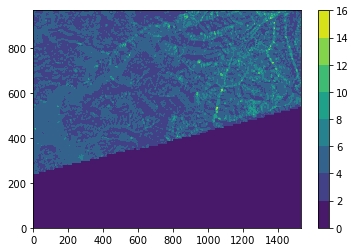

In [62]:
arr = loadArray("Japan_data/pre-event/download.B2_uint8.tif")

plot = plt.contourf(arr)
cbar = plt.colorbar(plot)